In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Завантаження та підготовка даних
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
# Перетворення зображень у формат RGB (VGG16 очікує 3 канали)
train_images = tf.image.grayscale_to_rgb(tf.expand_dims(train_images, -1))
test_images = tf.image.grayscale_to_rgb(tf.expand_dims(test_images, -1))

In [4]:
# Перетворення в float32 і нормалізація даних
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0

In [5]:
# Зміна розміру зображень до 32x32 (найменший розмір, який підтримує VGG16)
train_images = tf.image.resize(train_images, (32, 32))
test_images = tf.image.resize(test_images, (32, 32))

In [6]:
# Завантаження VGG16 без верхніх шарів
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [7]:
# Заморожування перших шарів (виділення ознак)
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [8]:
# Створення моделі
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='sigmoid')
])

In [9]:
# Компіляція моделі
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Функція для зміни швидкості навчання
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return float(lr * np.exp(-0.1))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
# Тренування моделі
history = model.fit(train_images, train_labels, epochs=30,
                    validation_split=0.2,
                    batch_size=128,
                    callbacks=[callback])

Epoch 1/30
375/375 [==============================] - 22s 31ms/step - loss: 0.4735 - accuracy: 0.8322 - val_loss: 0.3598 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 11s 28ms/step - loss: 0.3237 - accuracy: 0.8835 - val_loss: 0.3166 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 12s 32ms/step - loss: 0.2831 - accuracy: 0.8978 - val_loss: 0.2846 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 12s 32ms/step - loss: 0.2621 - accuracy: 0.9072 - val_loss: 0.2871 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 11s 29ms/step - loss: 0.2450 - accuracy: 0.9120 - val_loss: 0.3142 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 12s 31ms/step - loss: 0.2311 - accuracy: 0.9170 - val_loss: 0.2561 - val_accuracy: 0.9103 - lr: 9.0484e-04
Epoch 7/30
375/375 [==============================] - 

In [12]:
# Оцінка моделі
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочність на тестових даних: {test_acc}')

313/313 - 4s - loss: 1.0144 - accuracy: 0.9089 - 4s/epoch - 11ms/step

Точність на тестових даних: 0.9089000225067139


In [13]:
# Розморожування всіх шарів для тонкого налаштування
base_model.trainable = True

In [14]:
# Перекомпіляція моделі
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Донавчання моделі
history_fine = model.fit(train_images, train_labels, epochs=15,
                         validation_split=0.2,
                         batch_size=64,
                         callbacks=[callback])

Epoch 1/15
750/750 [==============================] - 37s 40ms/step - loss: 3.6485 - accuracy: 0.6589 - val_loss: 0.4984 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 28s 38ms/step - loss: 0.4280 - accuracy: 0.8489 - val_loss: 0.3705 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 29s 39ms/step - loss: 0.3490 - accuracy: 0.8767 - val_loss: 0.3235 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 28s 38ms/step - loss: 0.3282 - accuracy: 0.8837 - val_loss: 0.3380 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 28s 38ms/step - loss: 0.2754 - accuracy: 0.9024 - val_loss: 0.2610 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 28s 38ms/step - loss: 0.2465 - accuracy: 0.9139 - val_loss: 0.2765 - val_accuracy: 0.9078 - lr: 9.0484e-04
Epoch 7/15
750/750 [==============================] - 

In [16]:
# Оцінка моделі
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочність на тестових даних: {test_acc}')

313/313 - 2s - loss: 0.2829 - accuracy: 0.9244 - 2s/epoch - 8ms/step

Точність на тестових даних: 0.9243999719619751


In [17]:
# Функція для побудови графіків
def plot_learning_curves(history, title_suffix=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Графік точності
    ax1.plot(history.history['accuracy'], label='Тренувальна вибірка')
    ax1.plot(history.history['val_accuracy'], label='Валідаційна вибірка')
    ax1.set_title(f'Точність моделі {title_suffix}')
    ax1.set_ylabel('Точність')
    ax1.set_xlabel('Епоха')
    ax1.legend()

    # Графік втрат
    ax2.plot(history.history['loss'], label='Тренувальна вибірка')
    ax2.plot(history.history['val_loss'], label='Валідаційна вибірка')
    ax2.set_title(f'Втрати моделі {title_suffix}')
    ax2.set_ylabel('Втрати')
    ax2.set_xlabel('Епоха')
    ax2.legend()

    plt.tight_layout()
    plt.show()

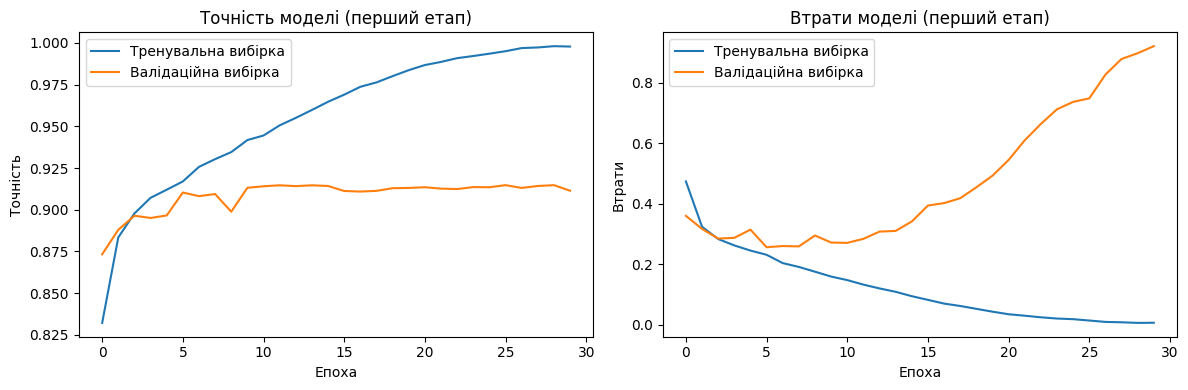

In [18]:
# Побудова графіків для першого етапу навчання
plot_learning_curves(history, "(перший етап)")

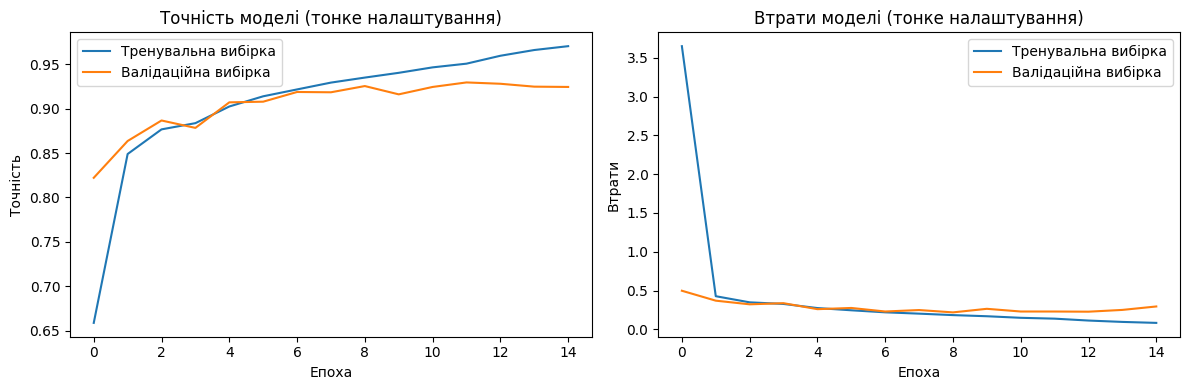

In [19]:
# Побудова графіків для етапу тонкого налаштування
plot_learning_curves(history_fine, "(тонке налаштування)")

### Висновки

Точність багатошарової мережі з попереднього завдання склала 0,89. Точність згорткової мережі з використанням VGG16 в якості згорткової основи при аналогічних параметрах склала 0,92 після донавчання та 0,91 до донавчання.